# OpenCV Face Recognition

The Face Recognition process in this tutorial is divided into three steps.

1. **Prepare training data:** In this step we will read training images for each person/subject along with their labels, detect faces from each image and assign each detected face an integer label of the person it belongs to.
2. **Train Face Recognizer:** In this step we will train OpenCV's LBPH face recognizer by feeding it the data we prepared in step 1.
3. **Testing:** In this step we will pass some test images to face recognizer and see if it predicts them correctly.

To detect faces, I will use the code from my previous article on [face detection](https://www.superdatascience.com/opencv-face-detection/). So if you have not read it, I encourage you to do so to understand how face detection works and its Python coding. 

## Import Required Modules

- **cv2:** is _OpenCV_ module for Python which we will use for face detection and face recognition.
- **os:** We will use this Python module to read our training directories and file names.
- **numpy:** We will use this module to convert Python lists to numpy arrays as OpenCV face recognizers accept numpy arrays.

In [1]:
#import OpenCV module
import cv2
#import os module for reading training data directories and paths
import os
#import numpy to convert python lists to numpy arrays as 
#it is needed by OpenCV face recognizers
import numpy as np

#matplotlib for display our images
import matplotlib.pyplot as plt
%matplotlib inline 

The more images used in training the better. Normally a lot of images are used for training a face recognizer so that it can learn different looks of the same person, for example with glasses, without glasses, laughing, sad, happy, crying, with beard, without beard etc. To keep our tutorial simple we are going to use only 12 images for each person. 

So our training data consists of total 2 persons with 12 images of each person. All training data is inside _`training-data`_ folder. _`training-data`_ folder contains one folder for each person and **each folder is named with format `sLabel (e.g. s1, s2)` where label is actually the integer label assigned to that person**. For example folder named s1 means that this folder contains images for person 1. The directory structure tree for training data is as follows:

```
training-data
|-------------- s1
|               |-- 1.jpg
|               |-- ...
|               |-- 12.jpg
|-------------- s2
|               |-- 1.jpg
|               |-- ...
|               |-- 12.jpg
```

The _`test-data`_ folder contains images that we will use to test our face recognizer after it has been successfully trained.

As OpenCV face recognizer accepts labels as integers so we need to define a mapping between integer labels and persons actual names so below I am defining a mapping of persons integer labels and their respective names. 

**Note:** As we have not assigned `label 0` to any person so **the mapping for label 0 is empty**. 

In [2]:
#there is no label 0 in our training data so subject name for index/label 0 is empty
subjects = ["", "Tom Cruise", "Shahrukh Khan"]

### Prepare training data

You may be wondering why data preparation, right? Well, OpenCV face recognizer accepts data in a specific format. It accepts two vectors, one vector is of faces of all the persons and the second vector is of integer labels for each face so that when processing a face the face recognizer knows which person that particular face belongs too. 

For example, if we had 2 persons and 2 images for each person. 

```
PERSON-1    PERSON-2   

img1        img1         
img2        img2
```

Then the prepare data step will produce following face and label vectors.

```
FACES                        LABELS

person1_img1_face              1
person1_img2_face              1
person2_img1_face              2
person2_img2_face              2
```


Preparing data step can be further divided into following sub-steps.

1. Read all the folder names of subjects/persons provided in training data folder. So for example, in this tutorial we have folder names: `s1, s2`. 
2. For each subject, extract label number. **Do you remember that our folders have a special naming convention?** Folder names follow the format `sLabel` where `Label` is an integer representing the label we have assigned to that subject. So for example, folder name `s1` means that the subject has label 1, s2 means subject label is 2 and so on. The label extracted in this step is assigned to each face detected in the next step. 
3. Read all the images of the subject, detect face from each image.
4. Add each face to faces vector with corresponding subject label (extracted in above step) added to labels vector. 

Did you read my last article on [face detection](https://www.superdatascience.com/opencv-face-detection/)? No? Then you better do so right now because to detect faces, I am going to use the code from my previous article on [face detection](https://www.superdatascience.com/opencv-face-detection/). So if you have not read it, I encourage you to do so to understand how face detection works and its coding. Below is the same code.

In [3]:
#function to detect face using OpenCV
def detect_face(img):
    #convert the test image to gray image as opencv face detector expects gray images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #load OpenCV face detector, I am using LBP which is fast
    #there is also a more accurate but slow Haar classifier
    face_cascade = cv2.CascadeClassifier('opencv-files/lbpcascade_frontalface.xml')

    #let's detect multiscale (some images may be closer to camera than others) images
    #result is a list of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    
    #if no faces are detected then return original img
    if (len(faces) == 0):
        return None, None
    
    #under the assumption that there will be only one face,
    #extract the face area
    (x, y, w, h) = faces[0]
    
    #return only the face part of the image
    return gray[y:y+w, x:x+h], faces[0]

I am using OpenCV's **LBP face detector**. On _line 4_, I convert the image to grayscale because most operations in OpenCV are performed in gray scale, then on _line 8_ I load LBP face detector using `cv2.CascadeClassifier` class. After that on _line 12_ I use `cv2.CascadeClassifier` class' `detectMultiScale` method to detect all the faces in the image. on _line 20_, from detected faces I only pick the first face because in one image there will be only one face (under the assumption that there will be only one prominent face). As faces returned by `detectMultiScale` method are actually rectangles (x, y, width, height) and not actual faces images so we have to extract face image area from the main image. So on _line 23_ I extract face area from gray image and return both the face image area and face rectangle.

Now you have got a face detector and you know the 4 steps to prepare the data, so are you ready to code the prepare data step? Yes? So let's do it. 

In [4]:
#this function will read all persons' training images, detect face from each image
#and will return two lists of exactly same size, one list 
# of faces and another list of labels for each face
def prepare_training_data(data_folder_path):
    
    #------STEP-1--------
    #get the directories (one directory for each subject) in data folder
    dirs = os.listdir(data_folder_path)
    
    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []
    
    #let's go through each directory and read images within it
    for dir_name in dirs:
        
        #our subject directories start with letter 's' so
        #ignore any non-relevant directories if any
        if not dir_name.startswith("s"):
            continue;
            
        #------STEP-2--------
        #extract label number of subject from dir_name
        #format of dir name = slabel
        #, so removing letter 's' from dir_name will give us label
        label = int(dir_name.replace("s", ""))
        
        #build path of directory containin images for current subject subject
        #sample subject_dir_path = "training-data/s1"
        subject_dir_path = data_folder_path + "/" + dir_name
        
        #get the images names that are inside the given subject directory
        subject_images_names = os.listdir(subject_dir_path)
        
        #------STEP-3--------
        #go through each image name, read image, 
        #detect face and add face to list of faces
        for image_name in subject_images_names:
            
            #ignore system files like .DS_Store
            if image_name.startswith("."):
                continue;
            
            #build image path
            #sample image path = training-data/s1/1.pgm
            image_path = subject_dir_path + "/" + image_name

            #read image
            image = cv2.imread(image_path)
            
            #display an image window to show the image 
            cv2.imshow("Training on image...", image)
            cv2.waitKey(100)
            
            #detect face
            face, rect = detect_face(image)
            
            #------STEP-4--------
            #for the purpose of this tutorial
            #we will ignore faces that are not detected
            if face is not None:
                #add face to list of faces
                faces.append(face)
                #add label for this face
                labels.append(label)
            
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    
    return faces, labels

I have defined a function that takes the path, where training subjects' folders are stored, as parameter. This function follows the same 4 prepare data substeps mentioned above. 

**(step-1)** On _line 8_ I am using `os.listdir` method to read names of all folders stored on path passed to function as parameter. On _line 10-13_ I am defining labels and faces vectors. 

**(step-2)** After that I traverse through all subjects' folder names and from each subject's folder name on _line 27_ I am extracting the label information. As folder names follow the `sLabel` naming convention so removing the  letter `s` from folder name will give us the label assigned to that subject. 

**(step-3)** On _line 34_, I read all the images names of of the current subject being traversed and on _line 39-66_ I traverse those images one by one. On _line 53-54_ I am using OpenCV's `imshow(window_title, image)` along with OpenCV's `waitKey(interval)` method to display the current image being traveresed. The `waitKey(interval)` method pauses the code flow for the given interval (milliseconds), I am using it with 100ms interval so that we can view the image window for 100ms. On _line 57_, I detect face from the current image being traversed. 

**(step-4)** On _line 62-66_, I add the detected face and label to their respective vectors.

But a function can't do anything unless we call it on some data that it has to prepare, right? Don't worry, I have got data of two beautiful and famous celebrities. I am sure you will recognize them!

![training-data](visualization/tom-shahrukh.png)

Let's call this function on images of these beautiful celebrities to prepare data for training of our Face Recognizer. Below is a simple code to do that.

In [5]:
#let's first prepare our training data
#data will be in two lists of same size
#one list will contain all the faces
#and other list will contain respective labels for each face
print("Preparing data...")
faces, labels = prepare_training_data("training-data")
print("Data prepared")

#print total faces and labels
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

Preparing data...
Data prepared
Total faces:  23
Total labels:  23


This was probably the boring part, right? Don't worry, the fun stuff is coming up next. It's time to train our own face recognizer so that once trained it can recognize new faces of the persons it was trained on. Read? Ok then let's train our face recognizer. 

### Train Face Recognizer

As OpenCV comes equipped with three face recognizers.

1. EigenFace Recognizer: This can be created with `cv2.face.createEigenFaceRecognizer()`
2. FisherFace Recognizer: This can be created with `cv2.face.createFisherFaceRecognizer()`
3. Local Binary Patterns Histogram (LBPH): This can be created with `cv2.face.LBPHFisherFaceRecognizer()`

I am going to use LBPH face recognizer but you can use any face recognizer of your choice. No matter which of the OpenCV's face recognizer you use the code will remain the same. You just have to change one line, the face recognizer initialization line given below. 

In [6]:
#create our LBPH face recognizer 
face_recognizer = cv2.face.createLBPHFaceRecognizer()

#or use EigenFaceRecognizer by replacing above line with 
#face_recognizer = cv2.face.createEigenFaceRecognizer()

#or use FisherFaceRecognizer by replacing above line with 
#face_recognizer = cv2.face.createFisherFaceRecognizer()

Now that we have initialized our face recognizer and we also have prepared our training data, it's time to train the face recognizer. We will do that by calling the `train(faces-vector, labels-vector)` method of face recognizer. 

In [7]:
#train our face recognizer of our training faces
face_recognizer.train(faces, np.array(labels))

**Did you notice** that instead of passing `labels` vector directly to face recognizer I am first converting it to **numpy** array? This is because OpenCV expects labels vector to be a `numpy` array. 

Still not satisfied? Want to see some action? Next step is the real action, I promise! 

### Prediction

Now comes my favorite part, the prediction part. This is where we actually get to see if our algorithm is actually recognizing our trained subjects's faces or not. We will take two test images of our celeberities, detect faces from each of them and then pass those faces to our trained face recognizer to see if it recognizes them. 

Below are some utility functions that we will use for drawing bounding box (rectangle) around face and putting celeberity name near the face bounding box. 

In [8]:
#function to draw rectangle on image 
#according to given (x, y) coordinates and 
#given width and heigh
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
#function to draw text on give image starting from
#passed (x, y) coordinates. 
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

First function `draw_rectangle` draws a rectangle on image based on passed rectangle coordinates. It uses OpenCV's built in function `cv2.rectangle(img, topLeftPoint, bottomRightPoint, rgbColor, lineWidth)` to draw rectangle. We will use it to draw a rectangle around the face detected in test image.

Second function `draw_text` uses OpenCV's built in function `cv2.putText(img, text, startPoint, font, fontSize, rgbColor, lineWidth)` to draw text on image. 

Now that we have the drawing functions, we just need to call the face recognizer's `predict(face)` method to test our face recognizer on test images. Following function does the prediction for us.

In [9]:
#this function recognizes the person in image passed
#and draws a rectangle around detected face with name of the 
#subject
def predict(test_img):
    #make a copy of the image as we don't want to chang original image
    img = test_img.copy()
    #detect face from the image
    face, rect = detect_face(img)

    #predict the image using our face recognizer 
    label= face_recognizer.predict(face)
    #get name of respective label returned by face recognizer
    label_text = subjects[label]
    
    #draw a rectangle around face detected
    draw_rectangle(img, rect)
    #draw name of predicted person
    draw_text(img, label_text, rect[0], rect[1]-5)
    
    return img

* **line-6** read the test image
* **line-7** detect face from test image
* **line-11** recognize the face by calling face recognizer's `predict(face)` method. This method will return a lable
* **line-12** get the name associated with the label
* **line-16** draw rectangle around the detected face
* **line-18** draw name of predicted subject above face rectangle

Predicting images...
Prediction complete


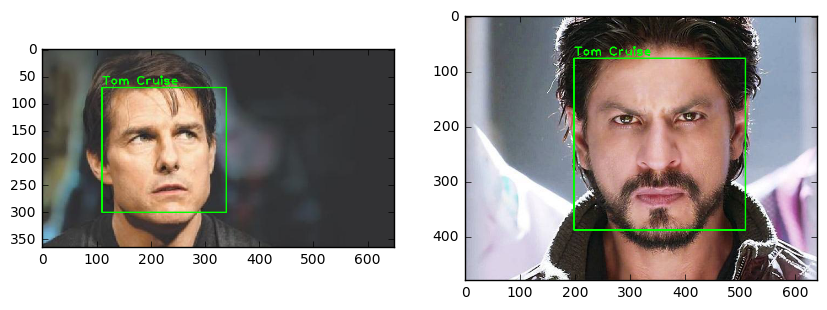

In [10]:
print("Predicting images...")

#load test images
test_img1 = cv2.imread("test-data/test1.jpg")
test_img2 = cv2.imread("test-data/test2.jpg")

#perform a prediction
predicted_img1 = predict(test_img1)
predicted_img2 = predict(test_img2)
print("Prediction complete")

#create a figure of 2 plots (one for each test image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#display test image1 result
ax1.imshow(cv2.cvtColor(predicted_img1, cv2.COLOR_BGR2RGB))

#display test image2 result
ax2.imshow(cv2.cvtColor(predicted_img2, cv2.COLOR_BGR2RGB))

#display both images
cv2.imshow("Tom cruise test", predicted_img1)
cv2.imshow("Shahrukh Khan test", predicted_img2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.destroyAllWindows()